# **How to perform a phase space simulation**

Prepare the notebook with the preambles for the inclusion of pandas, numpy and matplotlib.pyplot.
Import the data file (csv format) into Google Colab through the drive.mount command, import the pylorentz package.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Install the **phasespace** python package.
This is equivalent to what has been traditionally done with the root TGenPhaseSpace class, which is based of the GENBOD function of the CERNLIB FORTRAN libraries and which requires a full working ROOT installation.

In [2]:
!pip install phasespace

Let's start with a simple two body decay at rest: $B^0\rightarrow K^+\pi^-$.

In [3]:
import phasespace

B0_MASS = 5279.65
PION_MASS = 139.57018
KAON_MASS = 493.677
numberOfEvents = 10000

weights, particles = phasespace.nbody_decay(B0_MASS,
                                            [PION_MASS, KAON_MASS]).generate(n_events=numberOfEvents)

The simulation produces a dictionary (particles) of TensorFlow objects. Each object can be addresses with particles ['p_i'], where "i" is the number of the i-th generated particle.

In [4]:
particles

{'p_0': <tf.Tensor: shape=(10000, 4), dtype=float64, numpy=
 array([[ -887.45999601, -2307.46457941,  -851.79255705,  2618.58901417],
        [ 1474.35627745,  1330.47997807,  1701.06589675,  2618.58901417],
        [ -860.68251812,  -459.84337121, -2425.96336884,  2618.58901417],
        ...,
        [  949.86793335,   577.23439755, -2366.87134197,  2618.58901417],
        [  867.74370785,  2273.24744914,  -957.54659543,  2618.58901417],
        [-1638.95711524,  -392.76021162, -1999.27176255,  2618.58901417]])>,
 'p_1': <tf.Tensor: shape=(10000, 4), dtype=float64, numpy=
 array([[  887.45999601,  2307.46457941,   851.79255705,  2661.06098583],
        [-1474.35627745, -1330.47997807, -1701.06589675,  2661.06098583],
        [  860.68251812,   459.84337121,  2425.96336884,  2661.06098583],
        ...,
        [ -949.86793335,  -577.23439755,  2366.87134197,  2661.06098583],
        [ -867.74370785, -2273.24744914,   957.54659543,  2661.06098583],
        [ 1638.95711524,   392.760211

In [5]:
particles['p_0']

<tf.Tensor: shape=(10000, 4), dtype=float64, numpy=
array([[ -887.45999601, -2307.46457941,  -851.79255705,  2618.58901417],
       [ 1474.35627745,  1330.47997807,  1701.06589675,  2618.58901417],
       [ -860.68251812,  -459.84337121, -2425.96336884,  2618.58901417],
       ...,
       [  949.86793335,   577.23439755, -2366.87134197,  2618.58901417],
       [  867.74370785,  2273.24744914,  -957.54659543,  2618.58901417],
       [-1638.95711524,  -392.76021162, -1999.27176255,  2618.58901417]])>

Each TensorFlow object is a numpy.array: it can be saved in a tf object with a given name, and the component can be extracted as elements of np.arrays

In [6]:
piontf = particles['p_0']
kaontf = particles['p_1']

In [7]:
print(piontf.numpy())
print(' ')
# extract a single component of one of the particles objects
print(np.array(piontf[1][1]))
print(' ')
#to extract one column
print(np.array(piontf[:,1]))

[[ -887.45999601 -2307.46457941  -851.79255705  2618.58901417]
 [ 1474.35627745  1330.47997807  1701.06589675  2618.58901417]
 [ -860.68251812  -459.84337121 -2425.96336884  2618.58901417]
 ...
 [  949.86793335   577.23439755 -2366.87134197  2618.58901417]
 [  867.74370785  2273.24744914  -957.54659543  2618.58901417]
 [-1638.95711524  -392.76021162 -1999.27176255  2618.58901417]]
 
1330.4799780710343
 
[-2307.46457941  1330.47997807  -459.84337121 ...   577.23439755
  2273.24744914  -392.76021162]


One can now prepare pylorentz objects to make kinematic calculations with 4-vectors:

In [8]:
!pip install pylorentz
import math
from pylorentz import Momentum4

  Preparing metadata (setup.py) ... done
  Created wheel for pylorentz: filename=pylorentz-0.3.3-py3-none-any.whl size=12084 sha256=5c03677a82b99e3d4acd08012b813e6eaca336e2bc55922900eddbf8dda0052c
  Stored in directory: /root/.cache/pip/wheels/ec/8c/e8/b87f17eae26931058525533e2641e351203f95110d94f985cc
Successfully built pylorentz


In [9]:
kaonpx = np.array(kaontf[:,0])
kaonpy = np.array(kaontf[:,1])
kaonpz = np.array(kaontf[:,2])
pKT = np.sqrt(kaonpx**2+kaonpy**2)
pKmod = np.sqrt(pKT**2 + kaonpz**2)
etaK = np.arcsinh(kaonpz/pKT)
phiK = np.arctan2(kaonpy, kaonpx)
EK = np.array(kaontf[:,3])
kaon = Momentum4.e_eta_phi_p(EK, etaK, phiK, pKmod)

pPiT = np.sqrt((np.array(piontf[:,0]))**2+(np.array(piontf[:,1]))**2)
pPimod = np.sqrt(pPiT**2 + (np.array(piontf[:,2]))**2)
etaPi = np.arcsinh(np.array(piontf[:,2])/pPiT)
phiPi = np.arctan2(np.array(piontf[:,1]), np.array(piontf[:,0]))
pion = Momentum4.e_eta_phi_p(np.array(piontf[:,3]), etaPi, phiPi, pPimod)

# the mother (B0) is at rest
EB0 = B0_MASS*np.ones(numberOfEvents)
etaB0 = np.zeros(numberOfEvents)
phiB0 = np.zeros(numberOfEvents)
pB0 = np.zeros(numberOfEvents)
B0mother =  Momentum4.e_eta_phi_p(EB0, etaB0, phiB0, pB0)


Let's verify that the invariant mass of the kaon+pion system corresponds to the mass of the mother $B^0$. Let's plot also the momentum components of the two daugther particles.

Text(0.5, 1.0, 'z mom. component \n')

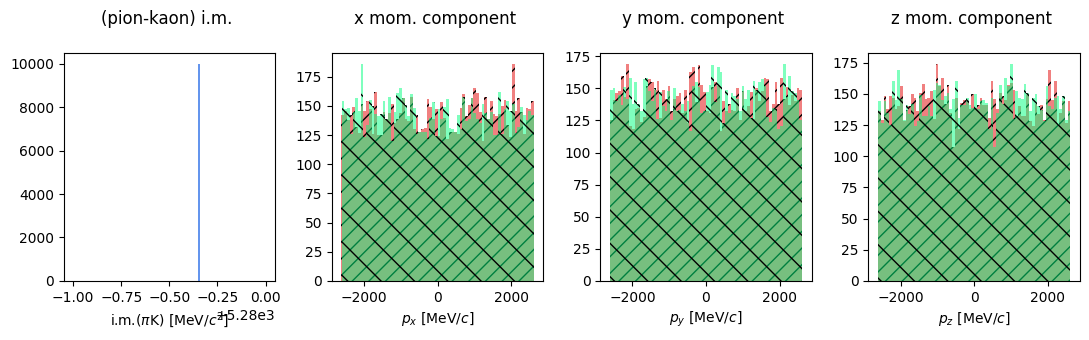

In [10]:
invariantMassKP = kaon+pion

fig, ax = plt.subplots(1,4, tight_layout=True, figsize=(11,3.5))
ax[0].hist(invariantMassKP.m, bins=100, color='CornFlowerBlue', range=(5279, 5280))
ax[0].set_xlabel('i.m.($\pi$K) [MeV/$c^2$]')
ax[0].set_title('(pion-kaon) i.m. \n')

ax[1].hist(kaon.p_x, bins=70, color='lightcoral', hatch='//')
ax[1].hist(pion.p_x, bins=70, color='springgreen', histtype='barstacked', hatch='\\', alpha=0.5)
ax[1].set_xlabel('$p_x$ [MeV/$c$]')
ax[1].set_title('x mom. component \n')

ax[2].hist(kaon.p_y, bins=70, color='lightcoral', hatch='//')
ax[2].hist(pion.p_y, bins=70, color='springgreen', histtype='barstacked', hatch='\\', alpha=0.5)
ax[2].set_xlabel('$p_y$ [MeV/$c$]')
ax[2].set_title('y mom. component \n')

ax[3].hist(kaon.p_z, bins=70, color='lightcoral', hatch='//')
ax[3].hist(pion.p_z, bins=70, color='springgreen', histtype='barstacked', hatch='\\', alpha=0.5)
ax[3].set_xlabel('$p_z$ [MeV/$c$]')
ax[3].set_title('z mom. component \n')

But it's monochromatic!! of course it is... it's a decay at rest. The momentum components are uniformly distributed in the available phase space.



---




Let's consider now
a three body decay like $B^0\rightarrow K^+\pi^-\pi^0$ and repeat the plot of the relevant kinematic variables. We can also make Dalitz plots this time.

In [11]:
numberOfEvents = 50000
PION0_MASS = 134.9766
weights, particles = phasespace.nbody_decay(B0_MASS,
                                            [PION_MASS, PION0_MASS ,KAON_MASS]).generate(n_events=numberOfEvents)

In [12]:
piontf = particles['p_0']
pion0tf = particles['p_1']
kaontf = particles['p_2']

kaonpx = np.array(kaontf[:,0])
kaonpy = np.array(kaontf[:,1])
kaonpz = np.array(kaontf[:,2])
pKT = np.sqrt(kaonpx**2+kaonpy**2)
pKmod = np.sqrt(pKT**2 + kaonpz**2)
etaK = np.arcsinh(kaonpz/pKT)
phiK = np.arctan2(kaonpy, kaonpx)
EK = np.array(kaontf[:,3])
kaon = Momentum4.e_eta_phi_p(EK, etaK, phiK, pKmod)

pPiT = np.sqrt((np.array(piontf[:,0]))**2+(np.array(piontf[:,1]))**2)
pPimod = np.sqrt(pPiT**2 + (np.array(piontf[:,2]))**2)
etaPi = np.arcsinh(np.array(piontf[:,2])/pPiT)
phiPi = np.arctan2(np.array(piontf[:,1]), np.array(piontf[:,0]))
pion = Momentum4.e_eta_phi_p(np.array(piontf[:,3]), etaPi, phiPi, pPimod)

pPi0T = np.sqrt((np.array(pion0tf[:,0]))**2+(np.array(pion0tf[:,1]))**2)
pPi0mod = np.sqrt(pPi0T**2 + (np.array(pion0tf[:,2]))**2)
etaPi0 = np.arcsinh(np.array(pion0tf[:,2])/pPi0T)
phiPi0 = np.arctan2(np.array(pion0tf[:,1]), np.array(pion0tf[:,0]))
pion0 = Momentum4.e_eta_phi_p(np.array(pion0tf[:,3]), etaPi0, phiPi0, pPi0mod)


# the mother (B0) is at rest
EB0 = B0_MASS*np.ones(numberOfEvents)
etaB0 = np.zeros(numberOfEvents)
phiB0 = np.zeros(numberOfEvents)
pB0 = np.zeros(numberOfEvents)
B0mother =  Momentum4.e_eta_phi_p(EB0, etaB0, phiB0, pB0)

Text(0, 0.5, 'i.m.$^2(\\pi^0K^+)$ [(MeV/$c^2)^2]$')

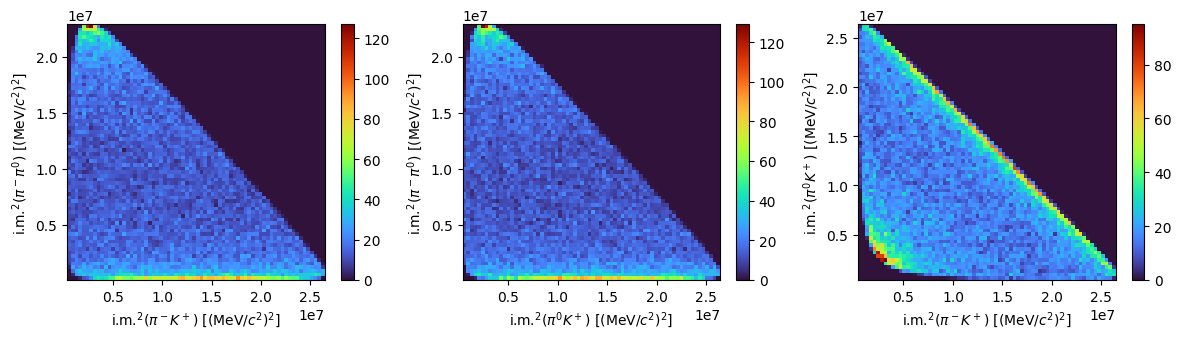

In [13]:
invariantMassKP = kaon+pion
invariantMassKPi0 = kaon+pion0
invariantMass2Pi = pion+pion0

fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(12,3.5))
f0 = ax[0].hist2d(invariantMassKP.m2, invariantMass2Pi.m2, bins=70, cmap='turbo')
fig.colorbar(f0[3], ax=ax[0])
ax[0].set_xlabel('i.m.$^2(\pi^-K^+)$ [(MeV/$c^2)^2]$')
ax[0].set_ylabel('i.m.$^2(\pi^-\pi^0)$ [(MeV/$c^2)^2]$')

f1 = ax[1].hist2d(invariantMassKPi0.m2, invariantMass2Pi.m2, bins=70, cmap='turbo')
fig.colorbar(f1[3], ax=ax[1])
ax[1].set_xlabel('i.m.$^2(\pi^0K^+)$ [(MeV/$c^2)^2]$')
ax[1].set_ylabel('i.m.$^2(\pi^-\pi^0)$ [(MeV/$c^2)^2]$')

f2 = ax[2].hist2d(invariantMassKP.m2, invariantMassKPi0.m2, bins=70, cmap='turbo')
fig.colorbar(f2[3], ax=ax[2])
ax[2].set_xlabel('i.m.$^2(\pi^-K^+)$ [(MeV/$c^2)^2]$')
ax[2].set_ylabel('i.m.$^2(\pi^0K^+)$ [(MeV/$c^2)^2]$')



---



The package *phasespace* allows to treat also multiple decays. Let's consider the $B^0\rightarrow K^{\ast 0}\gamma$ decay, followed by $K^{\ast 0}\rightarrow \pi^-K^+$. It can be simulated using the following procedure:

In [14]:
from phasespace import GenParticle

B0_MASS = 5279.65
KSTARZ_MASS = 895.55
PION_MASS = 139.57018
KAON_MASS = 493.677
GAMMA_MASS = 0.
numberOfEvents = 20000

kaonPlus = GenParticle('K+', KAON_MASS)
pionMinus = GenParticle('pi-', PION_MASS)
kstarZero = GenParticle('KStar', KSTARZ_MASS).set_children(kaonPlus, pionMinus)
gamma = GenParticle('gamma', GAMMA_MASS)
bZero = GenParticle('B0', B0_MASS).set_children(kstarZero, gamma)

weights, particles = bZero.generate(n_events=numberOfEvents)

In [15]:
particles

{'KStar': <tf.Tensor: shape=(20000, 4), dtype=float64, numpy=
 array([[-1884.57270825,  1406.13684125,  1022.05913154,  2715.77793272],
        [ 2273.70579884,  1184.6118804 ,   -19.91508257,  2715.77793272],
        [-2092.18256558, -1244.50027141,  -804.6310733 ,  2715.77793272],
        ...,
        [  595.84436592,  1080.9120213 , -2247.22910963,  2715.77793272],
        [  599.54806625, -1617.05800687,  1897.13085896,  2715.77793272],
        [ 1765.75982348,  1816.24437572,  -395.96539096,  2715.77793272]])>,
 'gamma': <tf.Tensor: shape=(20000, 4), dtype=float64, numpy=
 array([[ 1884.57270825, -1406.13684125, -1022.05913154,  2563.87206728],
        [-2273.70579884, -1184.6118804 ,    19.91508257,  2563.87206728],
        [ 2092.18256558,  1244.50027141,   804.6310733 ,  2563.87206728],
        ...,
        [ -595.84436592, -1080.9120213 ,  2247.22910963,  2563.87206728],
        [ -599.54806625,  1617.05800687, -1897.13085896,  2563.87206728],
        [-1765.75982348, -1816.24

In [16]:
#import tfTensors and store kinematics in pylorentz 4-momenta
piontf = particles['pi-']
gammatf = particles['gamma']
kaontf = particles['K+']
kaonStartf = particles['KStar']

kaonpx = np.array(kaontf[:,0])
kaonpy = np.array(kaontf[:,1])
kaonpz = np.array(kaontf[:,2])
pKT = np.sqrt(kaonpx**2+kaonpy**2)
pKmod = np.sqrt(pKT**2 + kaonpz**2)
etaK = np.arcsinh(kaonpz/pKT)
phiK = np.arctan2(kaonpy, kaonpx)
EK = np.array(kaontf[:,3])
kaon = Momentum4.e_eta_phi_p(EK, etaK, phiK, pKmod)

pPiT = np.sqrt((np.array(piontf[:,0]))**2+(np.array(piontf[:,1]))**2)
pPimod = np.sqrt(pPiT**2 + (np.array(piontf[:,2]))**2)
etaPi = np.arcsinh(np.array(piontf[:,2])/pPiT)
phiPi = np.arctan2(np.array(piontf[:,1]), np.array(piontf[:,0]))
pion = Momentum4.e_eta_phi_p(np.array(piontf[:,3]), etaPi, phiPi, pPimod)

pgammaT = np.sqrt((np.array(gammatf[:,0]))**2+(np.array(gammatf[:,1]))**2)
pgammamod = np.sqrt(pgammaT**2 + (np.array(gammatf[:,2]))**2)
etagamma = np.arcsinh(np.array(gammatf[:,2])/pgammaT)
phigamma = np.arctan2(np.array(gammatf[:,1]), np.array(gammatf[:,0]))
gamma = Momentum4.e_eta_phi_p(np.array(gammatf[:,3]), etagamma, phigamma, pgammamod)

pkaonStarT = np.sqrt((np.array(kaonStartf[:,0]))**2+(np.array(kaonStartf[:,1]))**2)
pkaonStarmod = np.sqrt(pkaonStarT**2 + (np.array(kaonStartf[:,2]))**2)
etakaonStar = np.arcsinh(np.array(kaonStartf[:,2])/pkaonStarT)
phikaonStar = np.arctan2(np.array(kaonStartf[:,1]), np.array(kaonStartf[:,0]))
kaonStar = Momentum4.e_eta_phi_p(np.array(kaonStartf[:,3]), etakaonStar, phikaonStar, pkaonStarmod)

# the mother (B0) is at rest
EB0 = B0_MASS*np.ones(numberOfEvents)
etaB0 = np.zeros(numberOfEvents)
phiB0 = np.zeros(numberOfEvents)
pB0 = np.zeros(numberOfEvents)
B0mother =  Momentum4.e_eta_phi_p(EB0, etaB0, phiB0, pB0)

Let's build the Dalitz plots matching particle pairs. The particles measured in the final state are $K^-,\; \pi^-$ and $\gamma$.

array([-9.09494702e-13,  0.00000000e+00,  1.81898940e-12, ...,
       -9.09494702e-13, -1.81898940e-12,  0.00000000e+00])

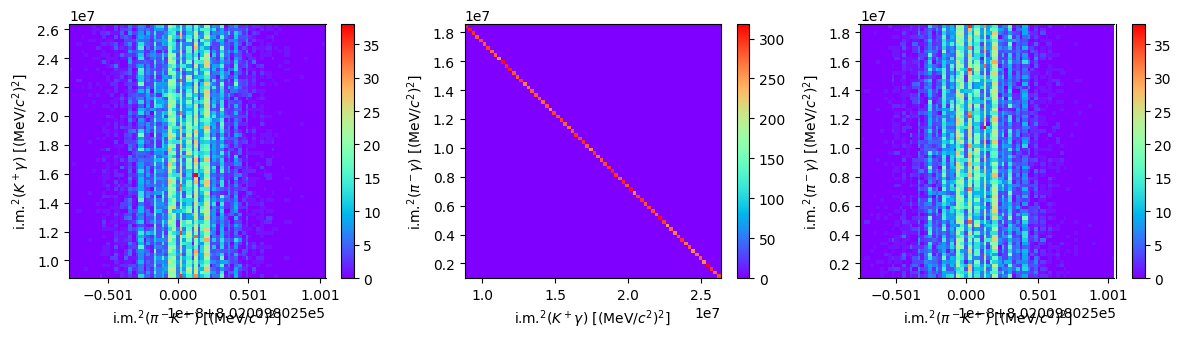

In [17]:
invariantMassKP = kaon+pion
invariantMassKGamma = kaon+gamma
invariantMassPiGamma = pion+gamma
s = (kaon + pion + gamma).m2
diffMass = B0mother.e - np.sqrt(s)

fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(12,3.5))
f0 = ax[0].hist2d(invariantMassKP.m2, invariantMassKGamma.m2, bins=70, cmap='rainbow')
fig.colorbar(f0[3], ax=ax[0])
ax[0].set_xlabel('i.m.$^2(\pi^-K^+)$ [(MeV/$c^2)^2]$')
ax[0].set_ylabel('i.m.$^2(K^+\gamma)$ [(MeV/$c^2)^2]$')

f1 = ax[1].hist2d(invariantMassKGamma.m2, invariantMassPiGamma.m2, bins=70, cmap='rainbow')
fig.colorbar(f1[3], ax=ax[1])
#f1 = ax[1].hist(invariantMassPiGamma.m, bins=70)
ax[1].set_xlabel('i.m.$^2(K^+\gamma)$ [(MeV/$c^2)^2]$')
ax[1].set_ylabel('i.m.$^2(\pi^-\gamma)$ [(MeV/$c^2)^2]$')

f2 = ax[2].hist2d(invariantMassKP.m2, invariantMassPiGamma.m2, bins=70, cmap='rainbow')
fig.colorbar(f2[3], ax=ax[2])
ax[2].set_xlabel('i.m.$^2(\pi^-K^+)$ [(MeV/$c^2)^2]$')
ax[2].set_ylabel('i.m.$^2(\pi^-\gamma)$ [(MeV/$c^2)^2]$')

diffMass

Now let's simulate a more realistic $K^\ast$ particle, not monochromatic but with a width of 47 MeV. The mass is extracted from a Gaussian distribution centered at the B0_MASS value and with $\sigma = 47/2.36 \sim 20$ MeV.
Ideally, one would simulate a big number of events but for the purpose of this exercise we need to keep this number as small as possible (say < 1000). You can try with larger numbers offline, though.  

In [18]:
#extract the mass value from a gaussian distribution
# keep the number small (much smaller than 1000!), the simulation iterated event by event takes very long
numberOfEvents = 500
# do you remember the difference between a BW sigma and a lorentzian FWHM?
# the widths you get out of the PDG booklet are FWHM's
sigmaKStar = 47/2.36   # do you remember the difference between a BW sigma and a lorentzian FWHM?
KStarResonanceMass = np.random.normal(KSTARZ_MASS, sigmaKStar, numberOfEvents)

In [19]:
kaonPlus = GenParticle('K+', KAON_MASS)
pionMinus = GenParticle('pi-', PION_MASS)
invMassKP = []
invMassKGamma = []
invMassPiGamma = []

for i in range(numberOfEvents):
#     kaonPlus = GenParticle('K+', KAON_MASS)
#     pionMinus = GenParticle('pi-', PION_MASS)
     kstarZero = GenParticle('KStar', KStarResonanceMass[i]).set_children(kaonPlus, pionMinus)
     gamma = GenParticle('gamma', GAMMA_MASS)
     bZero = GenParticle('B0', B0_MASS).set_children(kstarZero, gamma)
     weights, particles = bZero.generate(n_events=1)
     piontf = particles['pi-']
# kinematics
     gammatf = particles['gamma']
     kaontf = particles['K+']
     kaonStartf = particles['KStar']
     kaonpx = np.array(kaontf[:,0])
     kaonpy = np.array(kaontf[:,1])
     kaonpz = np.array(kaontf[:,2])
     pKT = np.sqrt(kaonpx**2+kaonpy**2)
     pKmod = np.sqrt(pKT**2 + kaonpz**2)
     etaK = np.arcsinh(kaonpz/pKT)
     phiK = np.arctan2(kaonpy, kaonpx)
     EK = np.array(kaontf[:,3])
     kaon = Momentum4.e_eta_phi_p(EK, etaK, phiK, pKmod)
     pPiT = np.sqrt((np.array(piontf[:,0]))**2+(np.array(piontf[:,1]))**2)
     pPimod = np.sqrt(pPiT**2 + (np.array(piontf[:,2]))**2)
     etaPi = np.arcsinh(np.array(piontf[:,2])/pPiT)
     phiPi = np.arctan2(np.array(piontf[:,1]), np.array(piontf[:,0]))
     pion = Momentum4.e_eta_phi_p(np.array(piontf[:,3]), etaPi, phiPi, pPimod)
     pgammaT = np.sqrt((np.array(gammatf[:,0]))**2+(np.array(gammatf[:,1]))**2)
     pgammamod = np.sqrt(pgammaT**2 + (np.array(gammatf[:,2]))**2)
     etagamma = np.arcsinh(np.array(gammatf[:,2])/pgammaT)
     phigamma = np.arctan2(np.array(gammatf[:,1]), np.array(gammatf[:,0]))
     gamma = Momentum4.e_eta_phi_p(np.array(gammatf[:,3]), etagamma, phigamma, pgammamod)
     pkaonStarT = np.sqrt((np.array(kaonStartf[:,0]))**2+(np.array(kaonStartf[:,1]))**2)
     pkaonStarmod = np.sqrt(pkaonStarT**2 + (np.array(kaonStartf[:,2]))**2)
     etakaonStar = np.arcsinh(np.array(kaonStartf[:,2])/pkaonStarT)
     phikaonStar = np.arctan2(np.array(kaonStartf[:,1]), np.array(kaonStartf[:,0]))
     kaonStar = Momentum4.e_eta_phi_p(np.array(kaonStartf[:,3]), etakaonStar, phikaonStar, pkaonStarmod)
# the mother (B0) is at rest
     EB0 = B0_MASS*np.ones(numberOfEvents)
     etaB0 = np.zeros(numberOfEvents)
     phiB0 = np.zeros(numberOfEvents)
     pB0 = np.zeros(numberOfEvents)
     B0mother =  Momentum4.e_eta_phi_p(EB0, etaB0, phiB0, pB0)
     #print((kaon+pion).m2)
# invariant masses arrays
     invMassKP.append((kaon+pion).m2)
     invMassKGamma.append((kaon+gamma).m2)
     invMassPiGamma.append((pion+gamma).m2)


Now you have all the 4-vectors to plot the invariant mass distributions for the different steps of the decay chains.

In [20]:
im1 = np.array(invMassKP)
im2 = np.array(invMassKGamma)
im3 = np.array(invMassPiGamma)

Text(0, 0.5, 'i.m.$^2(\\pi^-\\gamma)$ [(MeV/$c^2)^2]$')

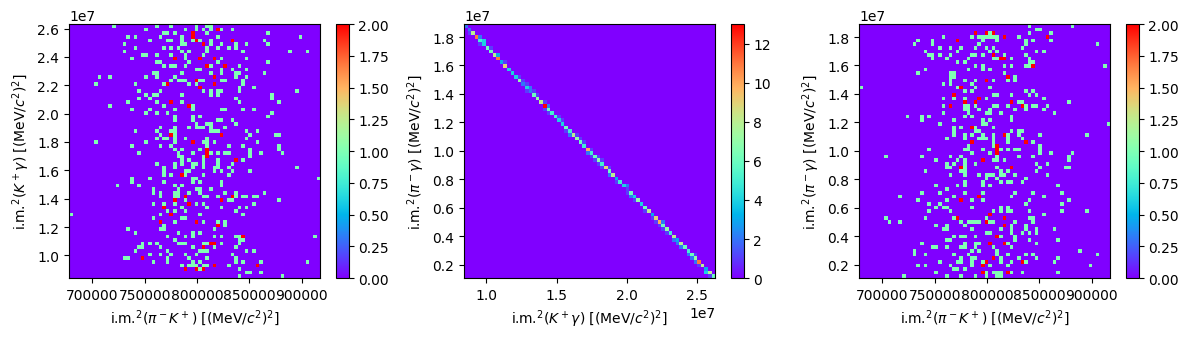

In [21]:
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(12,3.5))
#f0 = ax[0].hist2d(np.array(invMassKP), np.array(invMassKGamma), bins=70, cmap='rainbow')
f0 = ax[0].hist2d(im1[:,0], im2[:,0], bins=70, cmap='rainbow')
fig.colorbar(f0[3], ax=ax[0])
ax[0].set_xlabel('i.m.$^2(\pi^-K^+)$ [(MeV/$c^2)^2]$')
ax[0].set_ylabel('i.m.$^2(K^+\gamma)$ [(MeV/$c^2)^2]$')

f1 = ax[1].hist2d(np.array(invMassKGamma)[:,0], np.array(invMassPiGamma)[:,0], bins=70, cmap='rainbow')
fig.colorbar(f1[3], ax=ax[1])
#f1 = ax[1].hist(invariantMassPiGamma.m, bins=70)
ax[1].set_xlabel('i.m.$^2(K^+\gamma)$ [(MeV/$c^2)^2]$')
ax[1].set_ylabel('i.m.$^2(\pi^-\gamma)$ [(MeV/$c^2)^2]$')

f2 = ax[2].hist2d(np.array(invMassKP)[:,0], np.array(invMassPiGamma)[:,0], bins=70, cmap='rainbow')
fig.colorbar(f2[3], ax=ax[2])
ax[2].set_xlabel('i.m.$^2(\pi^-K^+)$ [(MeV/$c^2)^2]$')
ax[2].set_ylabel('i.m.$^2(\pi^-\gamma)$ [(MeV/$c^2)^2]$')